SymPy

In [1]:
from sympy import *
import numpy as np
from sympy import init_printing
init_printing(use_latex=True)

In [2]:
%matplotlib notebook
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt

import matplotlib.animation as animation

Variable initialisations

In [3]:
n = 2
'''
x = symbols('x0:{}'.format(n))
y = symbols('y0:{}'.format(n))
l = symbols('L0:{}'.format(n))
m = symbols('m0:{}'.format(n))
theta = symbols('theta_0:{}'.format(n))
'''
x = symarray('x', n)
y = symarray('y', n)
l = symarray('L', n)
m = symarray('m', n)
theta = symarray('theta', n)
t, g = symbols('t g')

State Equations

In [4]:
for j in range(0, n):
    x[j] = Add(*[l[i]*sin(theta[i](t)) for i in range(0, j+1)])
    y[j] = Add(*[l[i]*cos(theta[i](t)) for i in range(0, j+1)])

In [5]:
x

array([L_0*sin(theta_0(t)), L_0*sin(theta_0(t)) + L_1*sin(theta_1(t))], dtype=object)

In [6]:
print(Symbol('x0'), ":", x[0])

x0 : L_0*sin(theta_0(t))


Total Kinetic Energy T

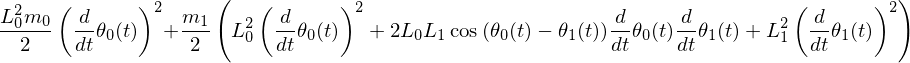

In [7]:
T = simplify(Rational(1, 2)*Add(*[m[i]*(x[i].diff(t)**2 + y[i].diff(t)**2) for i in range(0, n)]))
T

Total Potential Energy V

In [8]:
V = Add(*[-m[i]*g*y[i] for i in range(0, n)])
V

Lagrangian Lagra

In [9]:
thetadot = symarray('thetadot', n)

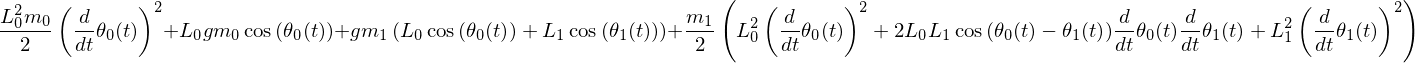

In [10]:
Lagra = (T - V)#.subs([(theta[i](t).diff(t), thetadot[i]) for i in range(0, n)])#.subs([(theta[i](t), theta[i]) for i in range(0, n)])
Lagra

In [11]:
term1 = symarray('term1', n)
term2 = symarray('term2', n)

In [12]:
term1 = [Lagra.diff(theta[i](t)) for i in range(0,n)]

In [13]:
term2 = [Lagra.diff(theta[i](t).diff(t)).diff(t) for i in range(0, n)]

In [14]:
eqn = symarray('eqn', n)
eqn = [term2[i] - term1[i] for i in range(0, n)]

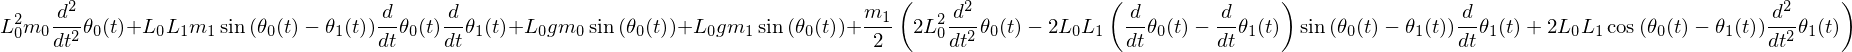

In [15]:
eqn[0]

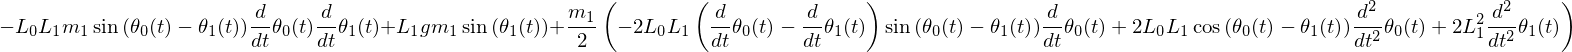

In [16]:
eqn[1]

In [17]:
thetaDd = solve(eqn, [theta[i](t).diff(t).diff(t) for i in range(0,n)])

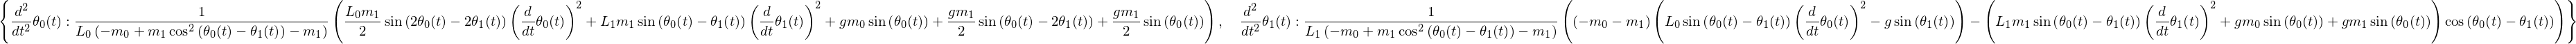

In [18]:
thetaDd

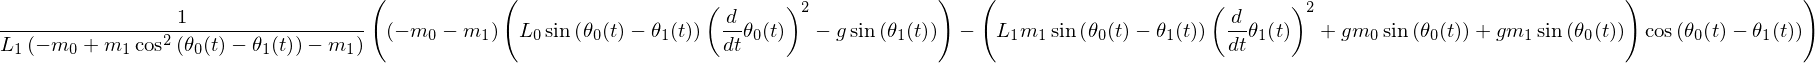

In [19]:
thetaDd[theta[1](t).diff(t).diff(t)]

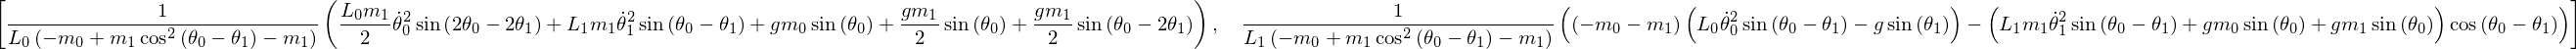

In [20]:
system_thetadotdot = [thetaDd[theta[j](t).diff(t, t)].\
                      subs([elem for elem_ in [\
                       [(theta[k](t).diff(t), thetadot[k]) for k in range(0,2)],\
                       [(theta[k](t), theta[k]) for k in range(0,2)]\
                      ] for elem in elem_]) for j in range(0,n)]
system_thetadotdot

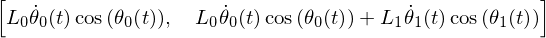

In [21]:
system_xdot = [x[i].diff(t).subs([(theta[j](t).diff(t), thetadot[j](t)) for j in range(0, n)]) for i in range(0, n)]
system_xdot

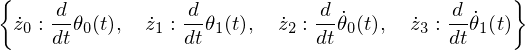

In [22]:
thetadotdot = symarray('thetadotdot', n)
z = symarray('z', n*2)
z_dot = symarray('zdot', n*2)
#z_dot = symbols('z0:4', cls=Function)
system_var_dict = {key : value for (key, value) in [elem for elem_ in [\
                                                    [(z[i], theta[i](t)) for i in range(0, n)],\
                                                    [(z[i], thetadot[i-n](t)) for i in range(n, 2*n)]\
                                                   ] for elem in elem_]}

system_dict = {key : value for (key, value) in [elem for elem_ in [\
                                                 [(z_dot[i], theta[i](t).diff(t)) for i in range(0, n)],\
                                                 [(z_dot[i], thetadot[i-n](t).diff(t)) for i in range(n, 2*n)]\
                                                ] for elem in  elem_]}
system_dict

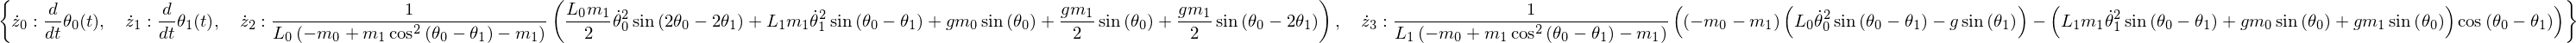

In [23]:
for i in range(n, 2*n): system_dict[z_dot[i]] = system_thetadotdot[i-n]
system_dict

In [24]:
sys_para = {m[0] : 1, m[1] : 2,\
            l[0] : 1, l[1] : 1, \
            g : 9.81}
sys_para

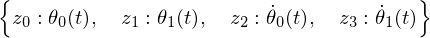

In [25]:
for i in range(0, n):
    system_dict[z_dot[i]] = thetadot[i]
    system_dict[z_dot[i+n]] = system_dict[z_dot[i+n]].subs([(key, sys_para[key]) for elem_ in \
                                                                          [m, l, [g]]\
                                                                                          \
                                                       for key in elem_])
system_var_dict

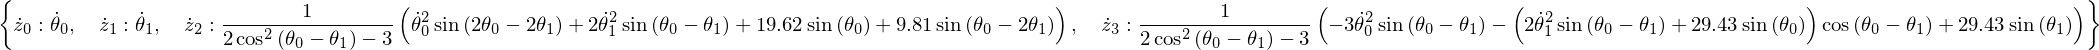

In [26]:
system_dict

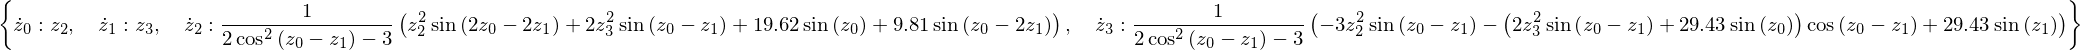

In [27]:
for i in range(0, n):
    system_dict[z_dot[i]] = z[i+n]
    system_dict[z_dot[i+n]] = system_dict[z_dot[i+n]].subs([elem for elem_ in[ \
                                                                          [(theta[j], z[j]) for j in range(0,n)],\
                                                                           [(thetadot[j], z[j+n]) for j in range(0,n)]\
                                                           ]for elem in elem_])
system_dict

In [28]:
f = list(symbols('f0:4', cls=Function))
f

[f0, f1, f2, f3]

NumPy

z_input = [theta[0], theta[1], thetadot[0], thetadot[1]]

In [29]:
z_input = np.array([np.pi+0.01, np.pi, 0, 0])
z_input

array([ 3.15159265,  3.14159265,  0.        ,  0.        ])

In [30]:
for i in range(0, 2*n):
    f[i] = lambdify(z, system_dict[z_dot[i]])

In [31]:
from scipy.integrate import odeint

In [32]:
num_iter = 100000
h = 0.01
t_linspace = np.linspace(0, num_iter * h, num_iter, endpoint=False)

In [33]:
def func(z0123, t):
    return [f[i](*z0123) for i in range (0, 2*n)]

In [34]:
z_t = odeint(func, z_input, t_linspace)

In [35]:
for i in range(0,n):
    x[i] = x[i].subs([(key, sys_para[key]) for elem_ in \
                                                                          [m, l, [g]]\
                                                                                          \
                                                       for key in elem_])
    y[i] = y[i].subs([(key, sys_para[key]) for elem_ in \
                                                                          [m, l, [g]]\
                                                                                          \
                                                       for key in elem_])


In [36]:
x_func = [lambdify([theta[j](t) for j in range(0, 2)], x[i]) for i in range(0, n)]
y_func = [lambdify([theta[j](t) for j in range(0, 2)], y[i]) for i in range(0, n)]

In [37]:
x_func[0](z_t[0, 0], z_t[0, 1])

<IPython.core.display.Javascript object>


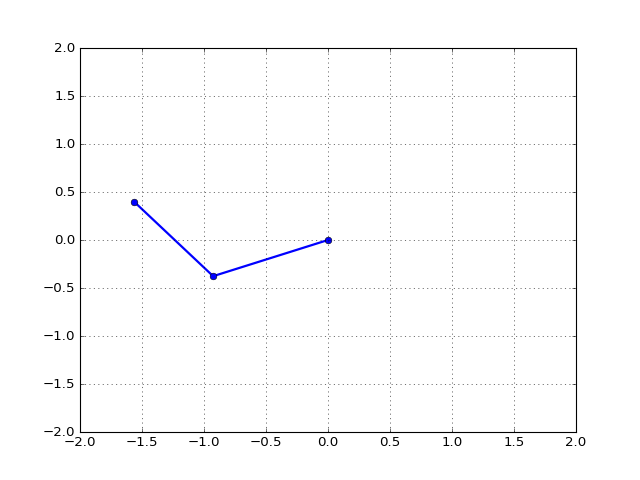

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
#time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
#    time_text.set_text('')
    return line, #time_text


def animate(i):
    thisx = [0, x_func[0](z_t[i, 0], z_t[i, 1]), x_func[1](z_t[i, 0], z_t[i, 1])]
    thisy = [0, -y_func[0](z_t[i, 0], z_t[i, 1]), -y_func[1](z_t[i, 0], z_t[i, 1])]

    line.set_data(thisx, thisy)
#    time_text.set_text(time_template % (i*dt))
    return line, #time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, num_iter),
                              interval=25, blit=True, init_func=init)
plt.show()